In [636]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation

import PIL
from PIL import Image
import cv2 as cv
import glob
import os
from tqdm import tqdm_notebook
%matplotlib inline

In [637]:
scene_dir = "scenes/scene_000/images/img_*"
scene_name = "blob_scene"
images = glob.glob(scene_dir)
images.sort()

In [638]:
print("num images: ", len(images), "ex: ",  images[0])

num images:  100 ex:  scenes/scene_000/images/img_0001.png


In [639]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

In [640]:
im = Image.open('/Users/yoni/Downloads/mnist.png')

def center_crop(image, size):

    x_low = image.width / 2 - size / 2
    x_high = image.width / 2 + size / 2
    y_low = image.height / 2 - size / 2
    y_high = image.height / 2 + size / 2
    
    image = image.crop((x_low, y_low, x_high, y_high))
    return image

im = center_crop(im, 1024)

im = im.resize((128, 128))


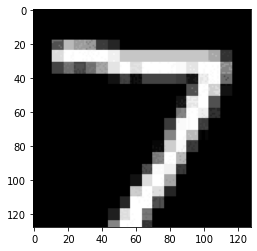

In [641]:
plt.imshow(im, cmap="gray")

In [642]:
noisy_img = np.array(im) + np.random.uniform(-10, 10, (128, 128))
img = np.array(im)

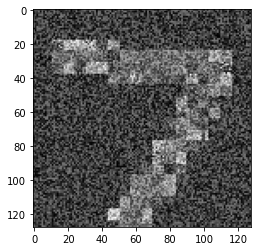

In [643]:
plt.imshow(noisy_img, cmap="gray")

In [644]:
class DataLoader(torch.utils.data.Dataset):
    def __init__(self, 
                 scene_dir="scenes/scene_000/images/",
                 textured="img_*", 
                 ground_truth="gt_*",
                 scene_name="scene", 
                 center_img=True,
                 resize=(256, 256),
                 load_gt = True,
                 frame_diff=False
        ):
        
        super(DataLoader, self).__init__()
        self.scene_dir = scene_dir
        self.scene_name = scene_name
        self.textured = glob.glob(scene_dir + textured)
        self.gt = glob.glob(scene_dir + ground_truth)
        self.frame_diff = frame_diff
        
        self.textured.sort()
        self.gt.sort()
        
        self.center_img = center_img
        self.resize = resize
        
        self.load_gt = load_gt
                
    def center_crop(self, image, size):
        x_low = image.width / 2 - size / 2
        x_high = image.width / 2 + size / 2
        y_low = image.height / 2 - size / 2
        y_high = image.height / 2 + size / 2

        image = image.crop((x_low, y_low, x_high, y_high))
        return image


    def transforms(self, img):
       
        if self.center_img:
            img = self.center_crop(img, 1024)

        if self.resize:
            img = img.resize(self.resize)
        
        toTensor = transforms.ToTensor()
        img = toTensor(img) / 255 
        return img
    
    def open(self, img):
        return Image.open(img).convert('L')
    
    def __len__(self):
        return len(self.images) - 1
    
    def __getitem__(self, idx):
        idx += 1
        image = self.open(self.textured[idx])
        textured = self.transforms(image)
        
        prev = self.transforms(self.open(self.textured[idx - 1]))
        if self.frame_diff:
            frame_diff = textured - prev
            textured = torch.cat((textured, frame_diff), axis=0)
        
        if self.load_gt:
            image = self.open(self.gt[idx])
            gt = self.transforms(image)
            return textured, gt
        
        return textured


In [645]:
trainloader = DataLoader(resize=(128, 128))

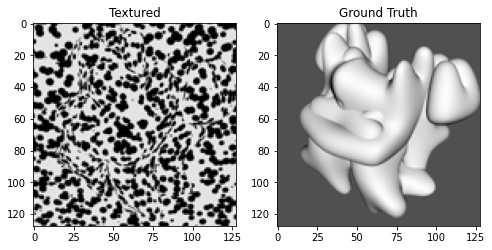

In [646]:
tex, gt = trainloader.__getitem__(0)

if trainloader.frame_diff:
    fig, axs = plt.subplots(1, 3, figsize=(12, 8))

    axs[0].imshow(tex[0, :], cmap="gray")
    axs[0].set_title("Textured")

    axs[1].imshow(tex[1, :], cmap="gray")
    axs[1].set_title("Difference from Previous Frame")

    axs[2].imshow(gt.squeeze(0), cmap="gray")
    axs[2].set_title("Ground Truth")

    plt.show()
else:
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))

    axs[0].imshow(tex[0, :], cmap="gray")
    axs[0].set_title("Textured")

    axs[1].imshow(gt.squeeze(0), cmap="gray")
    axs[1].set_title("Ground Truth")

    plt.show()

In [647]:
import torch.nn as nn

class DenoisingConv(nn.Module):
    
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(DenoisingConv, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, (3, 3))
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, (3, 3))
        self.deconv1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, (3, 3))
        self.deconv2 = nn.ConvTranspose2d(hidden_channels, out_channels, (3, 3))
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.selu(x)
        x = self.conv2(x)
        x = nn.functional.selu(x)
        x = self.deconv1(x)
        x = nn.functional.selu(x)
        x = self.deconv2(x)
        x = nn.functional.selu(x)
        return x

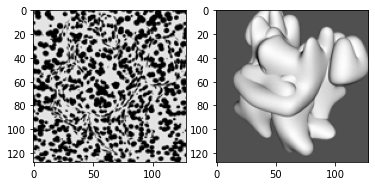

In [651]:
use_mnist = False
noisy_gestalt = False
use_frame_diff = False

if use_frame_diff:
    model = DenoisingConv(2, 64, 1)
else:
    model = DenoisingConv(1, 64, 1)

if use_mnist:
    tex, gt = noisy_img, img
    model = DenoisingConv(1, 64, 1)

    tex = torch.from_numpy(tex).unsqueeze(0).float() 
    gt = torch.from_numpy(gt).unsqueeze(0).float()

else:
    tex, gt = trainloader.__getitem__(0)
    if noisy_gestalt:
        gt = tex.float()
        tex = tex + np.random.uniform(0, 0.0015, gt.shape)
        tex = tex.float()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(tex.squeeze(0), cmap="gray")
ax[1].imshow(gt.squeeze(0), cmap="gray")
plt.show()

In [653]:

epochs = 1000
save_every = 10

train_preds = []
train_loss = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0003)

for epoch in range(epochs):

    optimizer.zero_grad()
    inp = tex.unsqueeze(0)
    
    out = model(inp)
    loss = torch.mean((out - gt.unsqueeze(0))**2)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if (epoch + 1) % save_every == 0:
        train_preds.append(out)

        print("Step %03d: loss --> %04f" %(epoch, loss.item()))

Step 009: loss --> 3.097761
Step 019: loss --> 3.097917
Step 029: loss --> 3.097936
Step 039: loss --> 3.097941
Step 049: loss --> 3.097942
Step 059: loss --> 3.097942
Step 069: loss --> 3.097942
Step 079: loss --> 3.097941
Step 089: loss --> 3.097941
Step 099: loss --> 3.097940
Step 109: loss --> 3.097939
Step 119: loss --> 3.097939
Step 129: loss --> 3.097937
Step 139: loss --> 3.097936
Step 149: loss --> 3.097935
Step 159: loss --> 3.097934
Step 169: loss --> 3.097933
Step 179: loss --> 3.097931
Step 189: loss --> 3.097929
Step 199: loss --> 3.097928
Step 209: loss --> 3.097926
Step 219: loss --> 3.097924
Step 229: loss --> 3.097921
Step 239: loss --> 3.097919
Step 249: loss --> 3.097916
Step 259: loss --> 3.097913
Step 269: loss --> 3.097909
Step 279: loss --> 3.097905
Step 289: loss --> 3.097901
Step 299: loss --> 3.097896
Step 309: loss --> 3.097890
Step 319: loss --> 3.097884
Step 329: loss --> 3.097877
Step 339: loss --> 3.097868
Step 349: loss --> 3.097860
Step 359: loss --> 3

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
def plot_img(img):
    img = img.detach().numpy()
    img = img.squeeze()
    plt.imshow(img)

In [634]:
model.eval()
out = model(tex.unsqueeze(0))

<IPython.core.display.Javascript object>


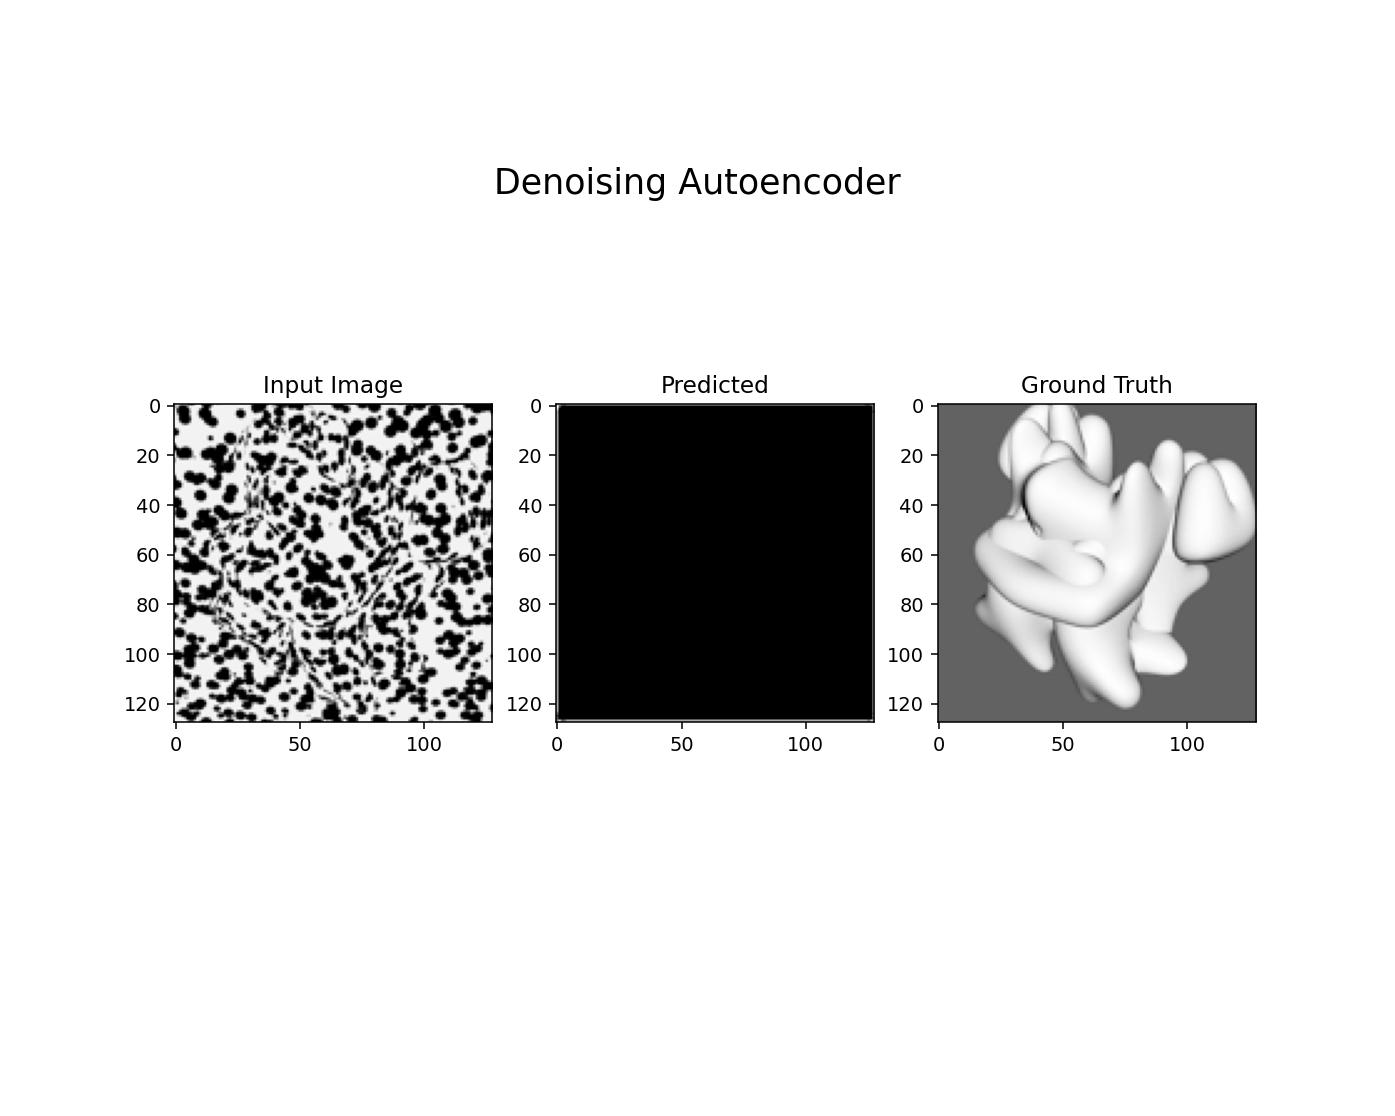

Text(0.5, 1.0, 'Ground Truth')

In [635]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
plt.suptitle("Denoising Autoencoder", fontsize=18, y=0.85)
axs[0].imshow(tex[0, :].squeeze() * -1, cmap="Greys")
axs[0].set_title("Input Image")
axs[1].imshow(out.detach().numpy()[0, 0] * -1, cmap="Greys")
axs[1].set_title("Predicted")
axs[2].imshow(gt.squeeze(0) * -1, cmap="Greys")
axs[2].set_title("Ground Truth")

<IPython.core.display.Javascript object>


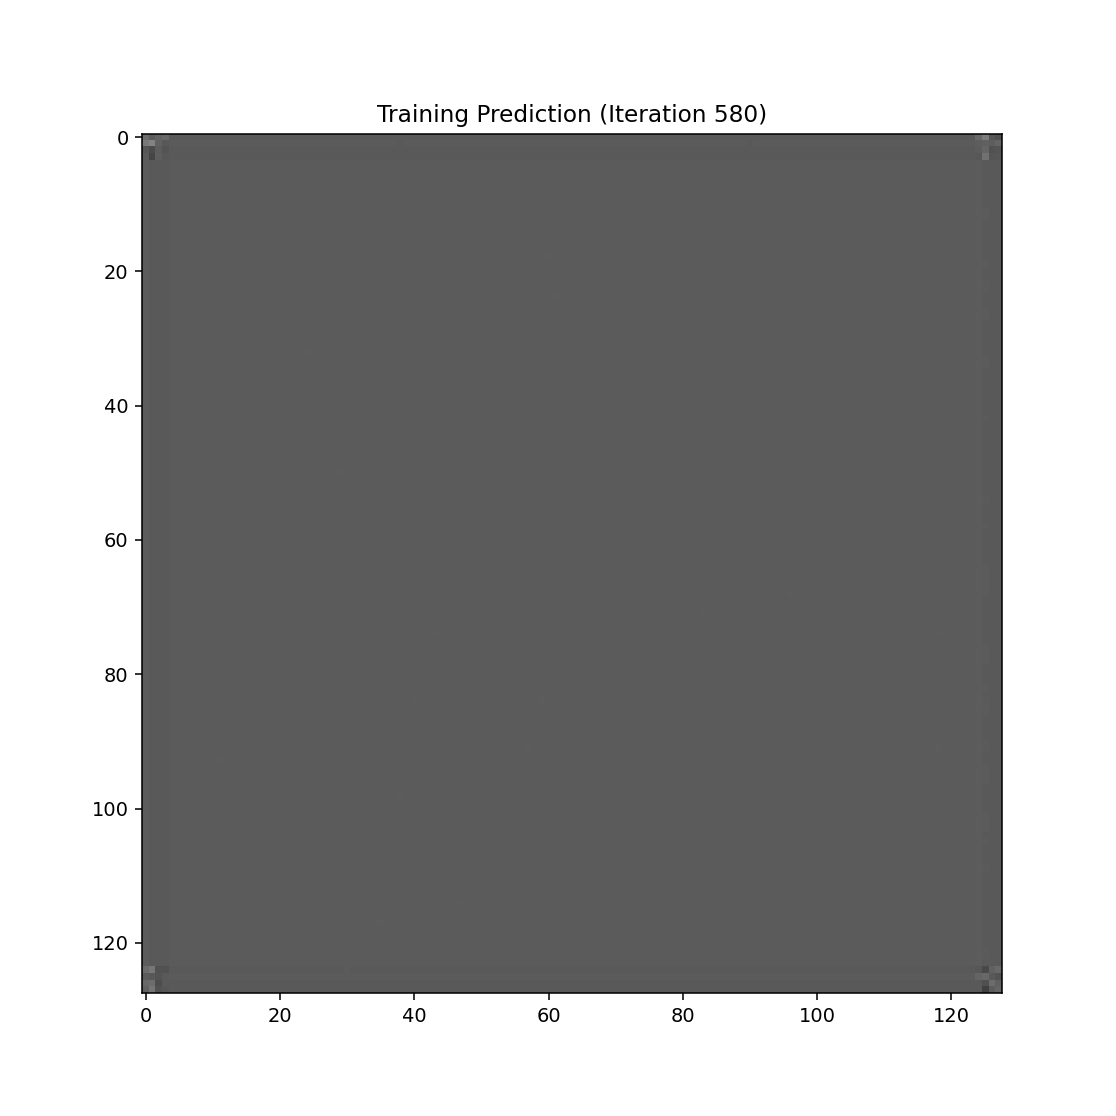

In [629]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(8,8))

img = ax.imshow(train_preds[0].detach().squeeze() * -1, cmap="gray")

def init():
    img.set_data(train_preds[0].detach().squeeze() * -1)
    return img, 

def update(frame):
    img.set_data(train_preds[frame].detach().squeeze() * -1)
    ax.set_title("")
    ax.set_title("Training Prediction (Iteration %d)" % (frame * 10))
    return img, 

ani = FuncAnimation(fig, update, frames=len(train_preds),
                    init_func=init, blit=True)
ani.save("/Users/yoni/Desktop/gestalt_denoising_test.mp4")

plt.show()


# Extract frame differencing

In [214]:
diffs = []
for i in range(1, len(images)):
    img_b = cv.imread(images[i])
    img_a = cv.imread(images[i-1])
    print(img_a.shape, img_b.shape)
    diff = img_b - img_a

    diffs.append(diff)

(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1920, 3) (1080, 1920, 3)
(1080, 1

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


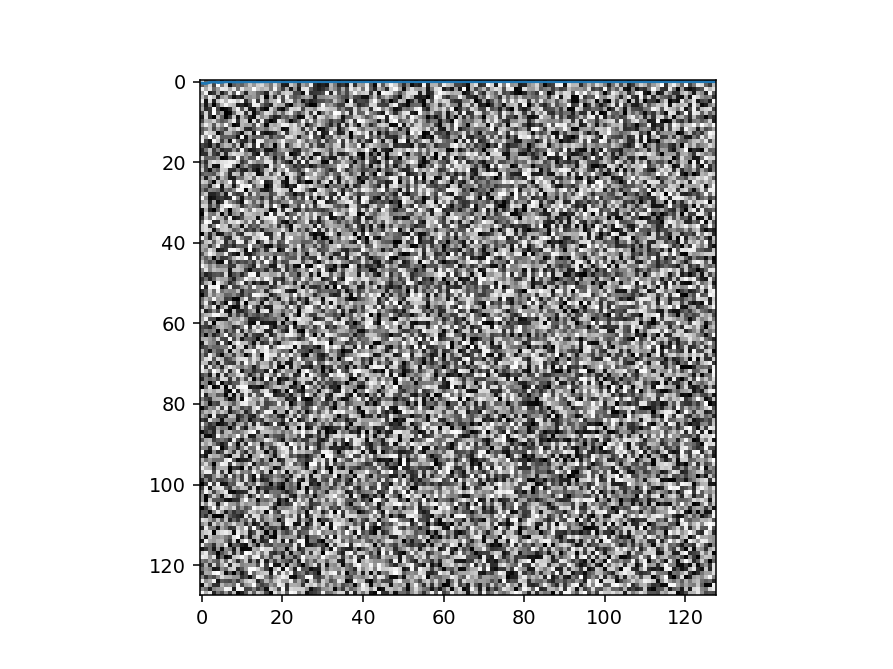

In [556]:
plt.imshow(gt.squeeze(0) + np.random.uniform(0, 0.001, size=(128, 128)))

<IPython.core.display.Javascript object>


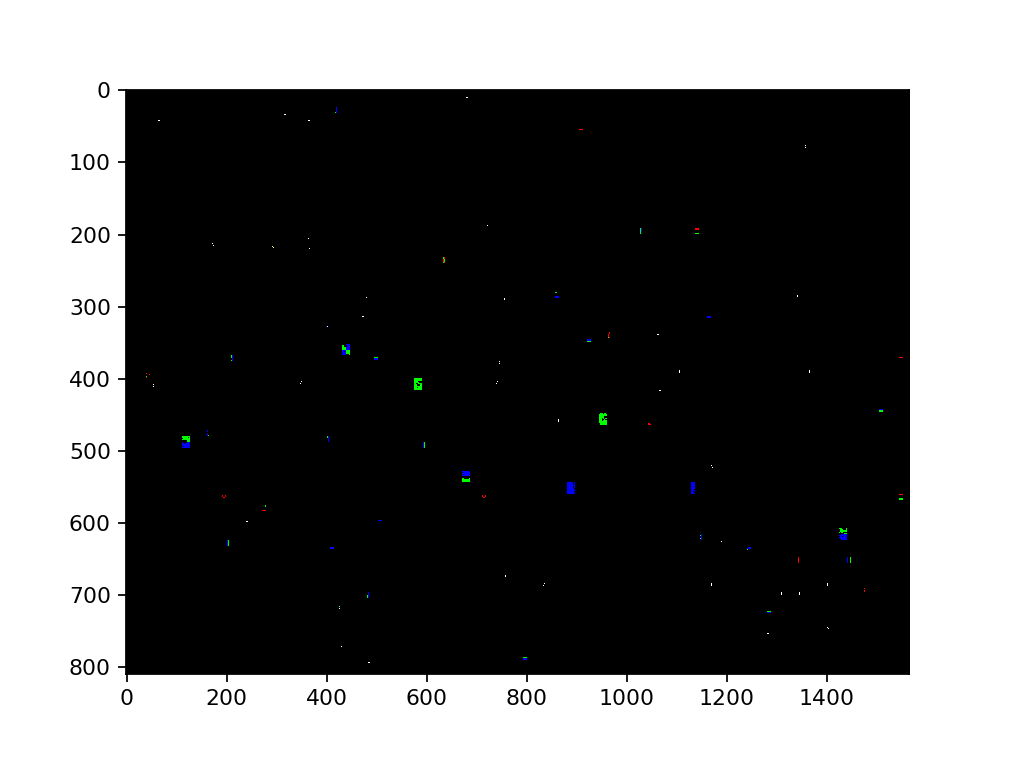

.......Done!


In [20]:
# Usually we use `%matplotlib inline`. However we need `notebook` for the anim to render in the notebook.
%matplotlib notebook
import matplotlib.animation as animation

fps = 20
nSeconds = int(len(diffs) / fps)
snapshots = diffs

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()

a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('media/frame_differencing/%s.mp4' % scene_name, fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

# plt.show()  # Not required, it s

# Extract Optical Flow

In [47]:
cap = cv.VideoCapture("movies/scene_000_tex.mp4")
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
while(1):
    ret, frame2 = cap.read()
    next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    cv.imshow('frame2',bgr)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png',frame2)
        cv.imwrite('opticalhsv.png',bgr)
    prvs = next

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [1]:
import torch 
import torch.nn as nn


In [8]:
cnn = nn.Sequential(*[nn.Conv2d(3, 128, 1, 2),
                    nn.ReLU(),
                    nn.Conv2d(128, 128, 1, 2),
                    nn.Conv2d(128, 128, 1, 2),
                     nn.Conv2d(128, 128, 1, 2)])

In [9]:
data = torch.randn((1, 3, 128, 128))

In [10]:
out = cnn(data)

In [11]:
out.shape

torch.Size([1, 128, 8, 8])

In [ ]:
nn.Conv2d(k)